In [2]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [3]:
SAMPLES = 256

In [4]:
# setup the FOGI model
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [5]:
mdl_datagen.fogi_errorgen_component_labels()

('H(X:0)_[]',
 'H(Y:0)_[]',
 'H(Z:0)_[]',
 'S(X:0)_[]',
 'S(Y:0)_[]',
 'S(Z:0)_[]',
 'H(X:0)_Gxpi2:0',
 'S(X:0)_Gxpi2:0',
 '(0.5 S(Y:0) + 0.5 S(Z:0))_Gxpi2:0',
 'H(Y:0)_Gypi2:0',
 '(0.5 S(X:0) + 0.5 S(Z:0))_Gypi2:0',
 'S(Y:0)_Gypi2:0',
 'ga(-H(Z:0))_Gypi2:0 - ga(-H(Z:0))_Gxpi2:0',
 'ga(H(Y:0))_rho0 - ga(H(Y:0))_Gxpi2:0',
 'ga(-H(Y:0))_Mdefault - ga(-H(Y:0))_Gxpi2:0',
 'ga(H(X:0))_rho0 - ga(H(X:0))_Gypi2:0',
 'ga(-H(X:0))_Mdefault - ga(-H(X:0))_Gypi2:0',
 'ga(-0.5 S(X:0) - 0.5 S(Y:0))_Mdefault - ga(-0.5 S(X:0) - 0.5 S(Y:0))_rho0')

In [6]:
hamiltonian_params = [0, 1, 2, 6, 9]
print([mdl_datagen.fogi_errorgen_component_labels()[i] for i in hamiltonian_params])

['H(X:0)_[]', 'H(Y:0)_[]', 'H(Z:0)_[]', 'H(X:0)_Gxpi2:0', 'H(Y:0)_Gypi2:0']


In [7]:
# add noise to the stochastic and hamiltonian parts of the FOGI rates
SEED = 3122
np.random.seed(SEED)

max_stochastic_error_rate = 0.001
hamiltonian_error_var = 0.05
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)


# add hamiltonian noise
ar[0:3] = np.random.normal(0, hamiltonian_error_var, 3)
ar[9] = np.random.normal(0, hamiltonian_error_var)
ar[6] = np.random.normal(0, hamiltonian_error_var)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
print('hamiltonian-only MSE with target', mserror(mdl_datagen, target_model))
print('hamiltonian-only agsi with target', avg_gs_infidelity(mdl_datagen, target_model))

# add stochastic noise
ar[3:6] = max_stochastic_error_rate*np.random.rand(3)
ar[7:9] = max_stochastic_error_rate*np.random.rand(2)
ar[10:12] = max_stochastic_error_rate*np.random.rand(2)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

print('MSE with target', mserror(mdl_datagen, target_model))
print('agi with target', avg_gs_infidelity(mdl_datagen, target_model))

hamiltonian-only MSE with target 0.013944923672360084
hamiltonian-only agsi with target 0.0027790049441692053
MSE with target 0.01394719147439365
agi with target 0.0034387883628380854


In [14]:
x = mdl_datagen[('Gxpi2', 0)]

In [19]:
x.submembers()[1].to_dense()

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  9.99148343e-01,  9.20468656e-22,
         8.35934494e-24],
       [ 0.00000000e+00, -9.20409669e-22,  9.97735890e-01,
         2.35500903e-02],
       [ 0.00000000e+00,  1.33591307e-23, -2.35500903e-02,
         9.97735890e-01]])

In [8]:
print('model is cptp', model_is_cptp(mdl_datagen))

model is cptp True


In [9]:
# make an edesign and simulate the data
maxLengths = [1,2,4,8,16]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [68]:
circ_list = edesign.circuit_lists[-1]
circ = circ_list[10]
print(circ)

Qubit 0 ---|Gypi2|-|Gypi2|---



In [48]:
x = mdl_datagen[('rho0')]

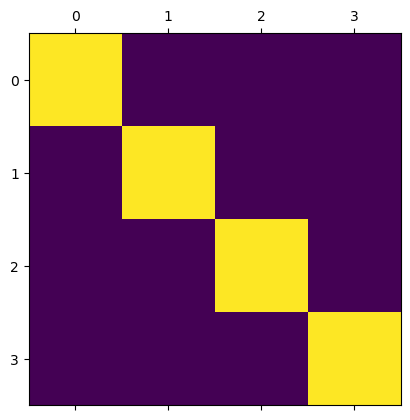

In [49]:
plt.matshow(x.submembers()[0].to_dense())

In [61]:
from scipy.linalg import logm

def left_product_map(circ, model):
    """
    returns 
        exp(L_1')exp(L_2')...exp(L_n') 
        i.e. the product of conjugated error processes
    """
    left_product = model[('Mdefault')].submembers()[0].to_dense()
    circ_slice = np.eye(left_product.shape[0])
    for i in range(len(circ)-1, -1, -1):
        left_product = left_product@circ_slice@model[circ[i]].submembers()[1].to_dense()@np.linalg.inv(circ_slice)
        circ_slice = circ_slice@model[circ[i]].submembers()[0].to_dense()
    left_product = left_product@circ_slice@model[('rho0')].submembers()[0].to_dense()
    return left_product

def loginf_norm(circ, model):
    lprod = left_product_map(circ, model)
    evals = np.linalg.eigvals(logm(lprod))
    return max(evals.imag) - min(evals.imag)

In [67]:
loginf_norm(edesign.circuit_lists[-1][5], mdl_datagen)

2.6501660339871993

In [74]:
norms = []
for i in range(0, len(circ_list), 1):
    norms.append(loginf_norm(circ_list[i], mdl_datagen))

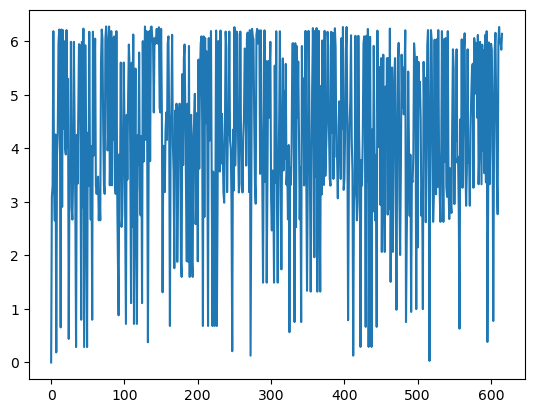

In [75]:
plt.plot(norms)